In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
MODEL_PATH = "../resources/models/shape_predictor_68_face_landmarks.dat"

In [13]:
class LipstickRecolorizer:
    def __init__(self, landmark_model_path):
        self.face_detector = dlib.get_frontal_face_detector()
        try:
            self.landmark_detector = dlib.shape_predictor(landmark_model_path)
        except:
            print(f"ERROR: unable to load landmark model in this path: {landmark_model_path}")
    
    def apply(self, image, color):
        all_landmarks, _ = self._get_facial_landmarks(image, return_numpy_landmark=True)
        lips_mask = self._extract_lips_region(image, all_landmarks)
        color_lips = np.zeros_like(image)
        color_lips[:] = color[0], color[1], color[2]
        color_lips = cv2.bitwise_and(lips_mask, color_lips)
        color_lips = cv2.GaussianBlur(color_lips, (5,5), 10)
        output_img = cv2.addWeighted(image, 1, color_lips, 0.4,0)
        return output_img
    
    def _extract_lips_region(self, image, all_landmarks):
        mask = np.zeros_like(image)
        for landmarks in all_landmarks:
            mask = cv2.fillPoly(mask, [landmarks[48:61]], (255,255,255))
        return mask
        
    def _get_facial_landmarks(self, image, return_numpy_landmark=False):
        face_rects = self.face_detector(image, 0)
        all_facial_landmarks = []
        face_bboxes = []
        for face in face_rects:
            face_bbox = (int(face.left()), 
                         int(face.top()), 
                         int(face.right()),
                         int(face.bottom()))
            rect = dlib.rectangle(face_bbox[0], face_bbox[1], face_bbox[2], face_bbox[3])
            landmarks = self.landmark_detector(image, rect)
            if return_numpy_landmark:
                temp_list = []
                for i in range(68):
                    x, y = landmarks.part(i).x, landmarks.part(i).y
                    temp_list.append([x,y])
                all_facial_landmarks.append(np.array(temp_list))
            else:
                all_facial_landmarks.append(landmarks)
            face_bboxes.append(face_bbox)
        return all_facial_landmarks, face_bboxes

In [7]:
IMAGE_PATH = "../resources/images/girl-no-makeup.jpg"
im = cv2.imread(IMAGE_PATH)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [24]:
LIPS_COLOR = (200, 0, 100)
lips_recolor = LipstickRecolorizer(MODEL_PATH)
im_out = lips_recolor.apply(im_rgb, LIPS_COLOR)

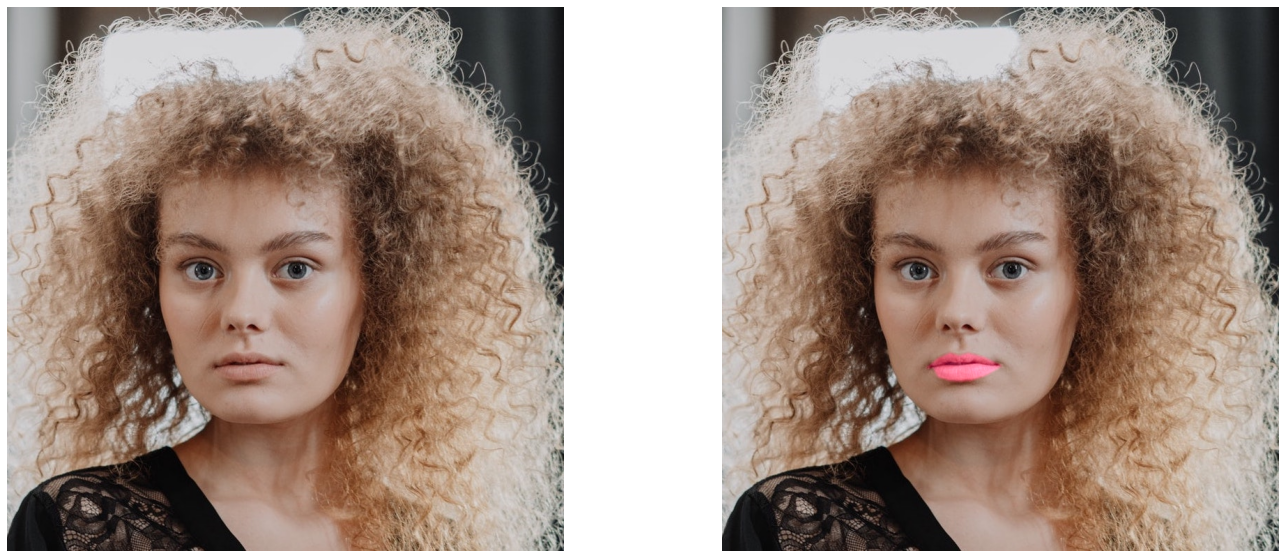

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
axes[0].imshow(im_rgb)
axes[0].axis("off")
axes[1].imshow(im_out)
axes[1].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)